# Freight PVAR - Dry Van Market

In [1]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import seaborn as sns
from scipy.stats import skew, pearsonr
import statsmodels.api as sm

## Load data

### For fututre conveniance transform .dta file to .parquet

In [2]:
## raw data - Make it comment if already loaded
# df = pd.read_stata("data/data_extended.dta")
# df = df.drop(columns =['index'])
# df.to_parquet("data/data_extended.parquet", index=False)

In [3]:
df = pd.read_parquet("data/data_extended.parquet") 

## Data pre-processing

In [4]:
### Keep only dry van 
df = df[df['equip_type'] == 'V']

### Delete unecessary columns
df = df.drop(columns =[ 'miles', 'concat', 'concat_2', 'equip_type'])
df = df.rename(columns={'kma_ob': 'id'})

### Create week (sunday) feature

In [5]:
# Week period
df["t_period"] = df["date"].dt.to_period("W-SUN")

# Get Sunday date of the week - we need to do that  so end of the year weesk 53 is correctly handled
df["week"] = df["t_period"].dt.end_time.dt.normalize()
df = df.sort_values(by=['id', 'date'])

## Agregate to weekly KMA_OB level

In [6]:
df_kma_week = (
    df.groupby(['id', 'week'], as_index=False)
      .agg(
          lane=('lane', 'nunique'),
          R=('rate', 'mean'),
          F=('fuel_rate', 'mean'),
          E=('ep', 'sum'),
          L=('lp', 'sum'),
      )
)

df_kma_week.sort_values(['id', 'week'], inplace=True)

df_kma_week

,id,week,lane,R,F,E,L
0,AZ_PHO,2018-05-06,38,1.546141,NaN,35144.0,184587.0
1,AZ_PHO,2018-05-13,34,1.610149,NaN,46124.0,281069.0
2,AZ_PHO,2018-05-20,38,1.695826,NaN,42119.0,407592.0
3,AZ_PHO,2018-05-27,36,1.815482,NaN,41952.0,386037.0
4,AZ_PHO,2018-06-03,31,1.943128,NaN,32521.0,303407.0
...,...,...,...,...,...,...,...
7825,WI_MIL,2023-04-02,116,2.198338,0.519568,410090.0,594986.0
7826,WI_MIL,2023-04-09,117,2.180318,0.531304,405937.0,460402.0
7827,WI_MIL,2023-04-16,111,2.137137,NaN,384002.0,419863.0
7828,WI_MIL,2023-04-23,115,2.061471,NaN,441334.0,401402.0


### Fil lin Fuel (Fallback strategy)

In [7]:
# Create time features
df_kma_week['month']= df_kma_week['week'].dt.month
df_kma_week['year']= df_kma_week['week'].dt.year

### Fill in missing values - Fuel (F)
fuel_1 = df_kma_week.groupby(['id', 'year','month'])['F'].mean().reset_index()
fuel_1 = fuel_1.rename(columns={'F': 'F_1'})

fuel_2 = df_kma_week.groupby(['id', 'year'])['F'].mean().reset_index()
fuel_2 = fuel_2.rename(columns={'F': 'F_2'})

fuel_fallback = fuel_1.merge(fuel_2, on = ['id', 'year'], how = 'left')
fuel_fallback['F_fallback'] = fuel_fallback['F_1'].fillna(fuel_fallback['F_2'])

## Now merge back with df_kma_week 
df_kma_week = df_kma_week.merge(fuel_fallback[['id', 'year','month','F_fallback']], on = ['id', 'year','month'], how = 'left')
df_kma_week['F'] = df_kma_week['F'].fillna(df_kma_week['F_fallback'])
df_kma_week = df_kma_week.drop(columns=['F_fallback'])

df_kma_week.isnull().sum()/ len(df_kma_week)

id       0.0
week     0.0
lane     0.0
R        0.0
F        0.0
E        0.0
L        0.0
month    0.0
year     0.0
dtype: float64

### Time filter (If needed)

In [8]:
df_kma_week = df_kma_week[df_kma_week['year']>=2019]

### Create continuos time feature

In [9]:
df_kma_week['t'] = (
    df_kma_week.groupby('id', observed=False)['week']
      .transform(lambda x: (x - x.min()).dt.days // 7 + 1)
)

df_kma_week


,id,week,lane,R,F,E,L,month,year,t
35,AZ_PHO,2019-01-06,28,1.720181,0.327063,45504.0,75990.0,1,2019,1
36,AZ_PHO,2019-01-13,40,1.590685,0.301623,82711.0,79835.0,1,2019,2
37,AZ_PHO,2019-01-20,42,1.552545,0.301196,94984.0,93652.0,1,2019,3
38,AZ_PHO,2019-01-27,42,1.502983,0.299815,93813.0,89214.0,1,2019,4
39,AZ_PHO,2019-02-03,42,1.513540,0.299044,77004.0,76884.0,2,2019,5
...,...,...,...,...,...,...,...,...,...,...
7825,WI_MIL,2023-04-02,116,2.198338,0.519568,410090.0,594986.0,4,2023,222
7826,WI_MIL,2023-04-09,117,2.180318,0.531304,405937.0,460402.0,4,2023,223
7827,WI_MIL,2023-04-16,111,2.137137,0.525436,384002.0,419863.0,4,2023,224
7828,WI_MIL,2023-04-23,115,2.061471,0.525436,441334.0,401402.0,4,2023,225


#### Testing if we have any duplicated rows?

In [10]:
# how many unique weeks overall?
T = df_kma_week['t'].nunique()
N = df_kma_week['id'].nunique()
print("N ids:", N, "T weeks:", T, "rows:", len(df_kma_week))

# per-id unique t count (should all equal T for a balanced panel)
n_t_by_id = df_kma_week.groupby('id')['t'].nunique().sort_values()
print(n_t_by_id.head(), n_t_by_id.tail())

# find duplicates of (id, t)
dups = (df_kma_week.groupby(['id','t']).size()
        .reset_index(name='n_rows')
        .query('n_rows > 1'))
print("duplicate (id,t) pairs:", len(dups))
dups.head()


N ids: 30 T weeks: 226 rows: 6780
id
AZ_PHO    226
CA_LAX    226
CA_ONT    226
CO_DEN    226
FL_LAK    226
Name: t, dtype: int64 id
TX_FTW    226
TX_HOU    226
UT_SLC    226
WI_GRE    226
WI_MIL    226
Name: t, dtype: int64
duplicate (id,t) pairs: 0


,id,t,n_rows


### Compute Capacity Indicator

count    6780.000000
mean        4.572478
std         3.971160
min         0.269414
25%         2.159978
50%         3.527530
75%         5.680953
max        66.237274
Name: C, dtype: float64

<Axes: xlabel='C', ylabel='Count'>

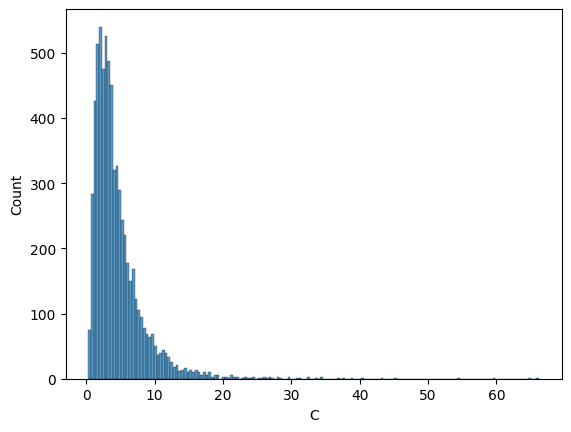

In [11]:
df_kma_week['C'] = df_kma_week['L'] / df_kma_week['E']
display(df_kma_week['C'].describe())
sns.histplot(df_kma_week['C'])

In [12]:
kma_stats = (
    df_kma_week.groupby('id', as_index=True)
      .agg(
        lane_mean=('lane', 'mean'),
        R_mean   =('R', 'mean'),
        R_std    =('R', 'std'),
        C_mean   =('C', 'mean'),
        C_max    =('C', 'max')
      )
)

kma_stats


,lane_mean,R_mean,R_std,C_mean,C_max
id,,,,,
AZ_PHO,59.544248,1.934951,0.536695,4.425542,13.877281
CA_LAX,117.455752,2.337293,0.693617,6.284652,18.217253
CA_ONT,105.495575,2.389572,0.665556,4.288164,14.488760
CO_DEN,88.831858,1.312967,0.266726,2.757405,12.568545
FL_LAK,86.924779,1.163922,0.259272,2.958760,11.476526
GA_ATL,121.092920,2.031551,0.420833,3.548240,11.202984
IL_CHI,130.880531,2.749045,0.587607,1.977075,7.080556
IL_JOL,129.407080,2.773506,0.585574,2.555268,8.767063
IN_IND,123.269912,2.535354,0.539458,3.061791,10.072592


### Replace Capacity outliers 

{'threshold': np.float64(17.5944), 'capped_rows': 80}
count    6780.000000
mean        4.474381
std         3.331734
min         0.269414
25%         2.159978
50%         3.527530
75%         5.680953
max        17.594432
Name: C, dtype: float64


<Axes: xlabel='C', ylabel='Count'>

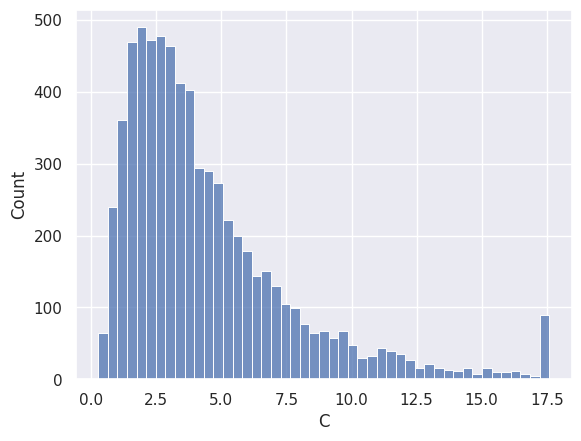

In [33]:
df_filtered = df_kma_week.copy()

# 1) compute global threshold on C (NaNs ignored)
q3  = df_filtered["C"].quantile(0.75)
sd  = df_filtered["C"].std()          # sample std (ddof=1 default)
thr = q3 + 3* sd

# 2) how many will be capped?
n_above = int((df_filtered["C"] > thr).sum())

# 3) replace values above threshold by the threshold
df_filtered["C"] = df_filtered["C"].clip(upper=thr)

print({"threshold": round(thr, 4), "capped_rows": n_above})
print(df_filtered["C"].describe())

sns.histplot(df_filtered['C'])

## KMA stats

In [34]:
kma_stats = (
    df_filtered.groupby(["id"], as_index=True, sort=True)
    .agg(
        {
            "lane": ["mean"],
            "R": ["mean", 'std'],
            "C": ["mean", 'max'],
        }
    )
)

kma_stats.columns = kma_stats.columns.droplevel(1)

kma_stats

,lane,R,R,C,C
id,,,,,
AZ_PHO,59.544248,1.934951,0.536695,4.425542,13.877281
CA_LAX,117.455752,2.337293,0.693617,6.279429,17.594432
CA_ONT,105.495575,2.389572,0.665556,4.288164,14.488760
CO_DEN,88.831858,1.312967,0.266726,2.757405,12.568545
FL_LAK,86.924779,1.163922,0.259272,2.958760,11.476526
GA_ATL,121.092920,2.031551,0.420833,3.548240,11.202984
IL_CHI,130.880531,2.749045,0.587607,1.977075,7.080556
IL_JOL,129.407080,2.773506,0.585574,2.555268,8.767063
IN_IND,123.269912,2.535354,0.539458,3.061791,10.072592


### Chart 1 - Capacity cycle analysis per KMA

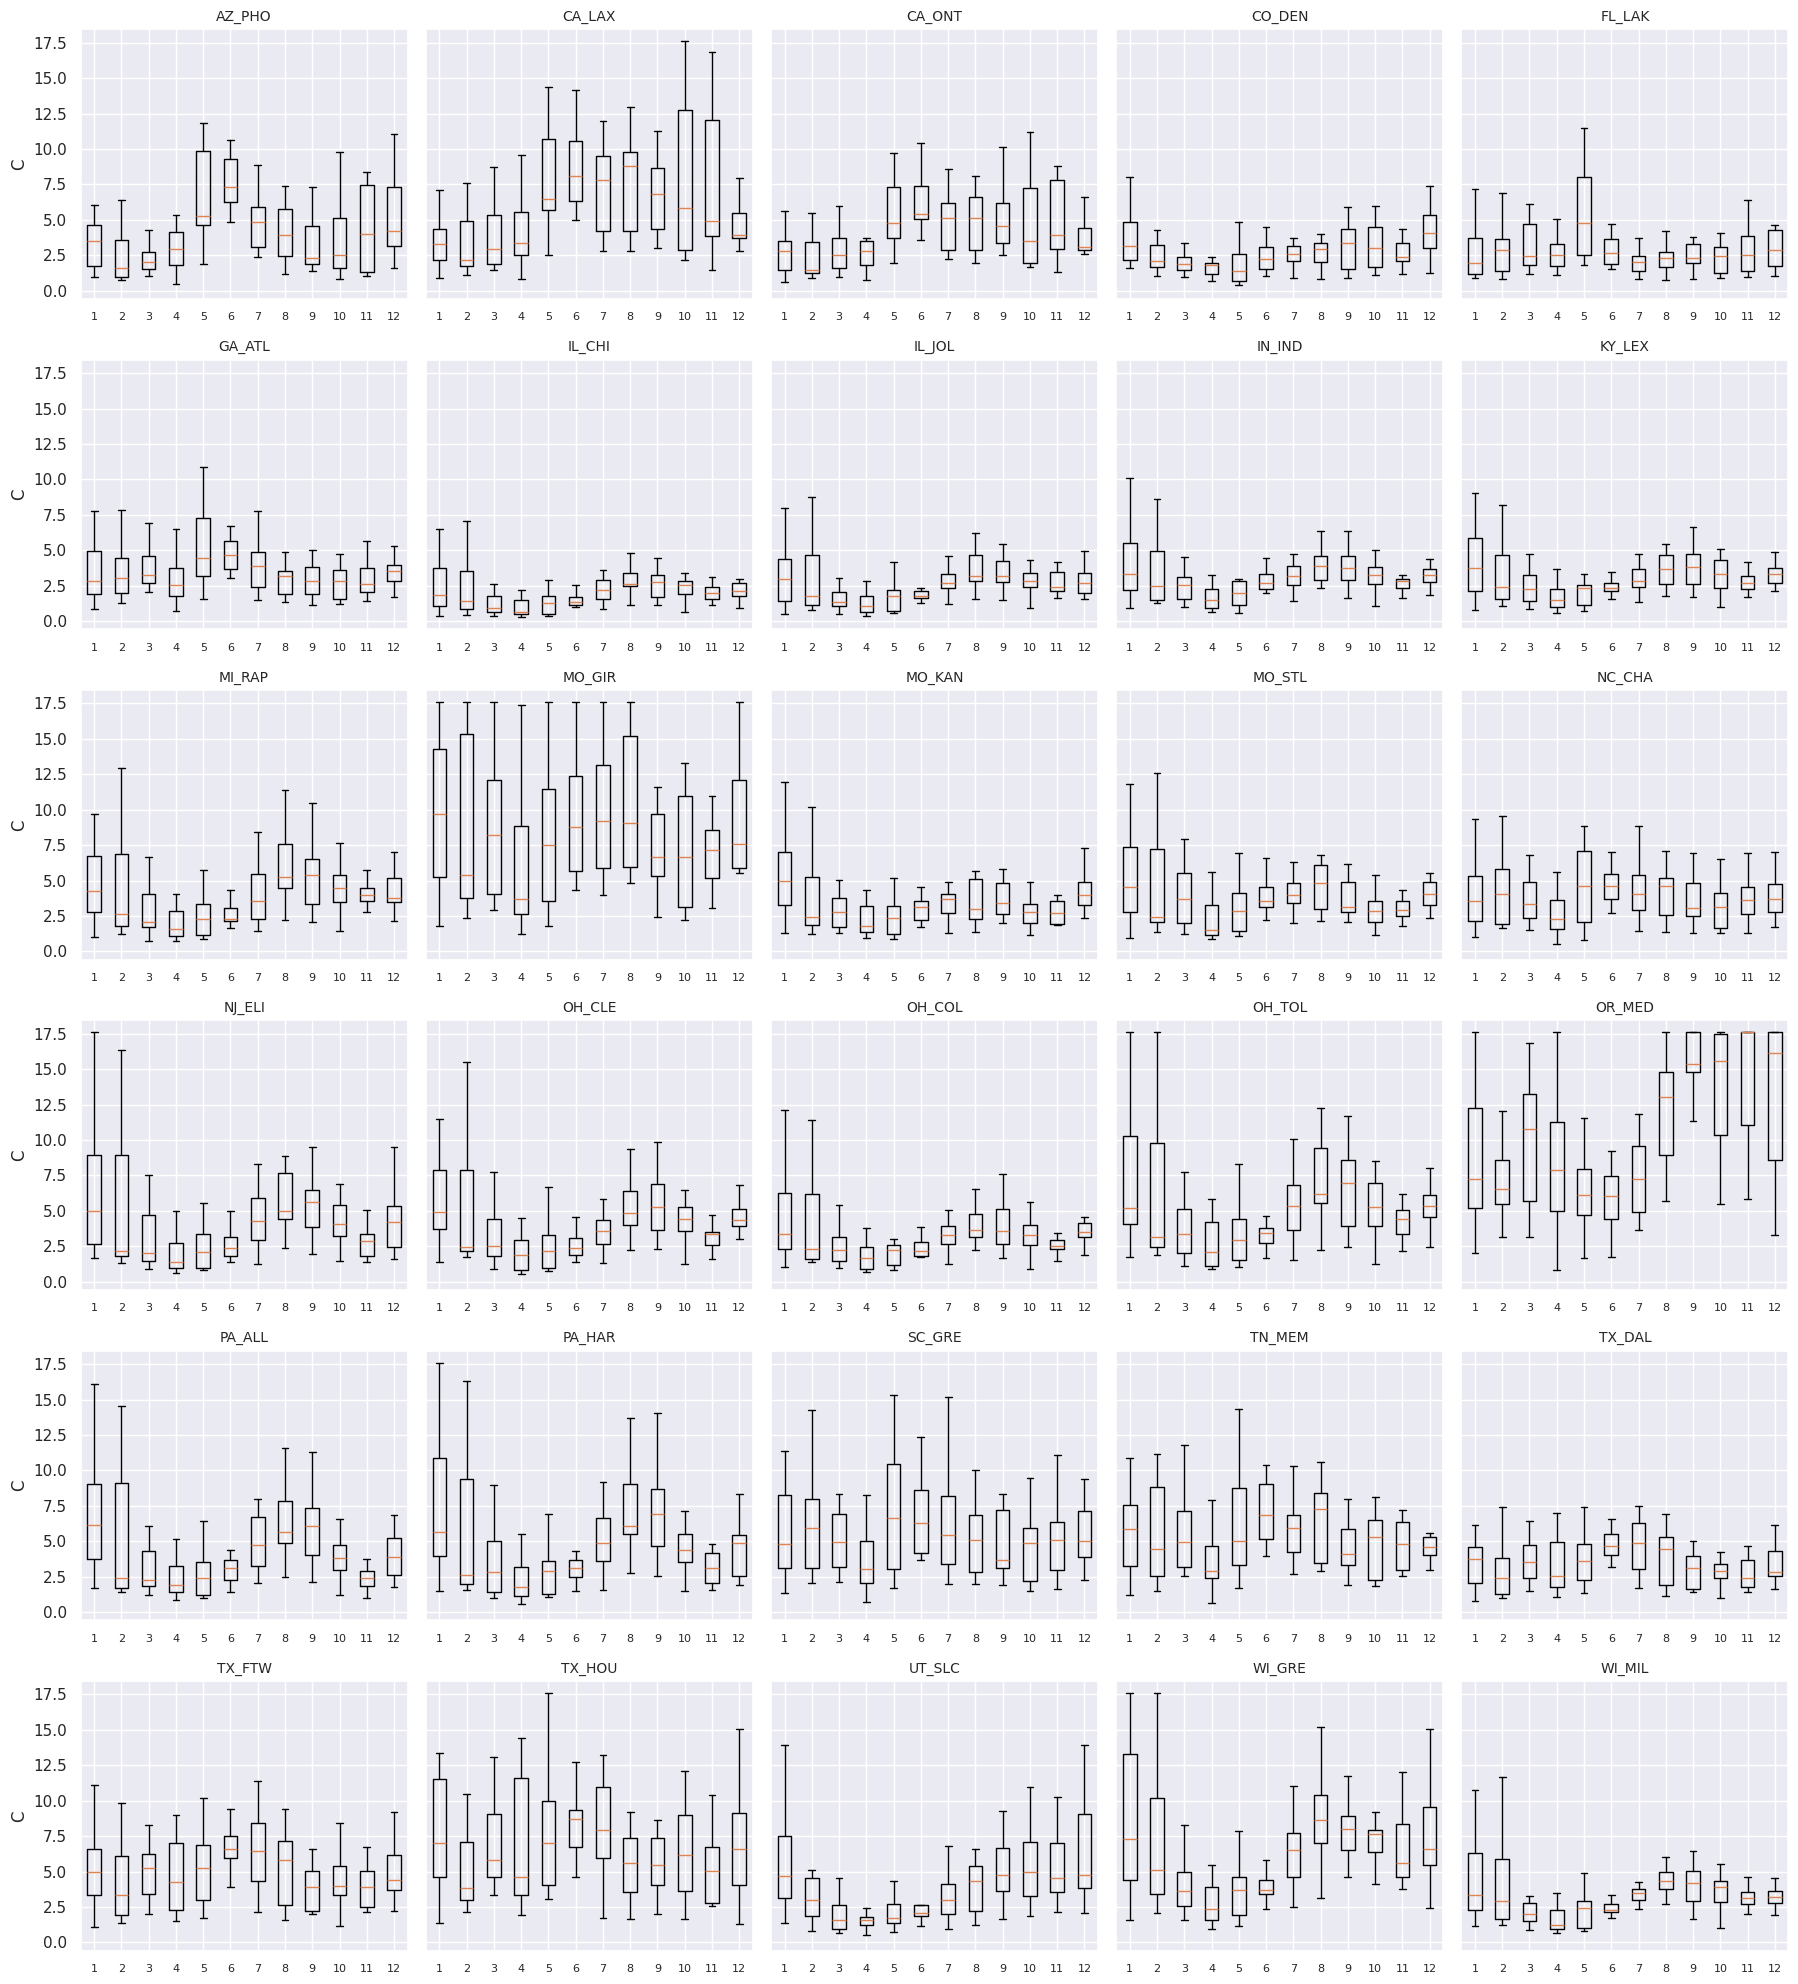

In [35]:
kmas = (df_filtered['id'].value_counts().head(30).index.tolist())
months = list(range(1, 13))

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(18, 20), sharey=True)
axes = axes.ravel()

for i, k in enumerate(kmas):
    ax = axes[i]
    d = df_filtered.loc[df_filtered['id'] == k, ['month','C']]
    data = [d.loc[d['month'] == m, 'C'].values for m in months]
    ax.boxplot(data, showfliers=False)
    ax.set_title(k, fontsize=10)
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(months, fontsize=8)
    if i % 5 == 0:
        ax.set_ylabel("C")

# hide any unused axes (if <30 KMA)
for j in range(len(kmas), len(axes)):
    axes[j].set_visible(False)

# fig.suptitle("C by Month per KMA (boxplots)", y=0.92, fontsize=14)
plt.tight_layout()
plt.show()


#### Capacity ratios are higher in the second half of the year, likely driven by holidays, Black Friday, and winter conditions

In [36]:
mask = ~df_filtered['id'].isin(['OR_MED','AZ_PHO','UT_SLC'])
df_filtered = df_kma_week.loc[mask].copy()

### Chart 2 - Freight Rate vs Equipment Posts (per KMA)

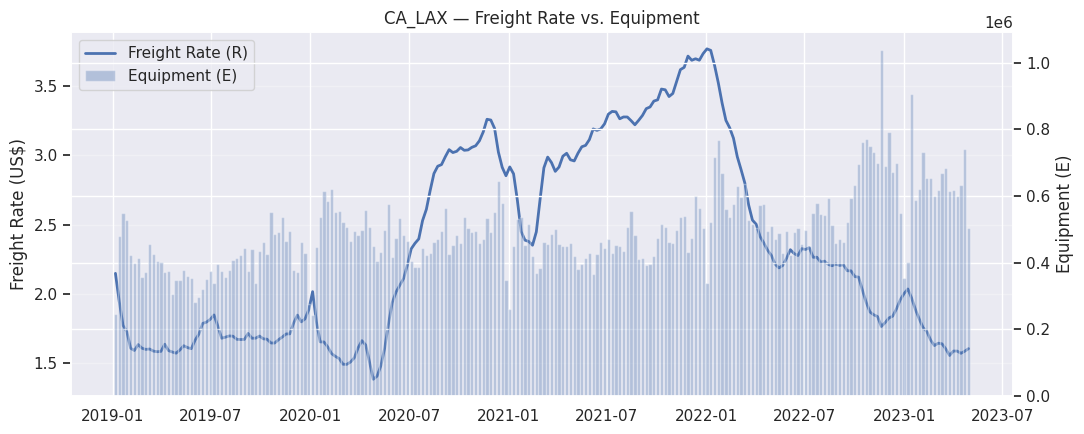

In [38]:
df_chart = df_filtered[df_filtered['id'] == 'CA_LAX']
df_chart

# --- pick the ID and filter (your sample shows 'CA_LAX')
kma_id = "CA_LAX"
df_chart = (
    df_filtered.loc[df_filtered['id'] == kma_id, ['week', 'R', 'E']]
      .dropna(subset=['week'])
      .sort_values('week')
      .copy()
)

# create the plot
fig, ax1 = plt.subplots(figsize=(11, 4.5))

# left y-axis: R as line
ax1.plot(df_chart['week'], df_chart['R'], label='Freight Rate (R)', linewidth=2, zorder=3)
ax1.set_ylabel('Freight Rate (US$)')
ax1.grid(True, axis='y', alpha=0.3)

# right y-axis: E as bars
ax2 = ax1.twinx()
# width given in days when x is datetime; 6 keeps bars nearly a week wide
ax2.bar(df_chart['week'], df_chart['E'], width=6, alpha=0.35, label='Equipment (E)', zorder=1)
ax2.set_ylabel('Equipment (E)')

# x-axis formatting
# ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# #ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# one legend combining both axes
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

ax1.set_title(f"{kma_id} — Freight Rate vs. Equipment")
fig.tight_layout()
plt.show()


### Chart 2 - Freight Rate vs Capacity Ratio (per KMA)

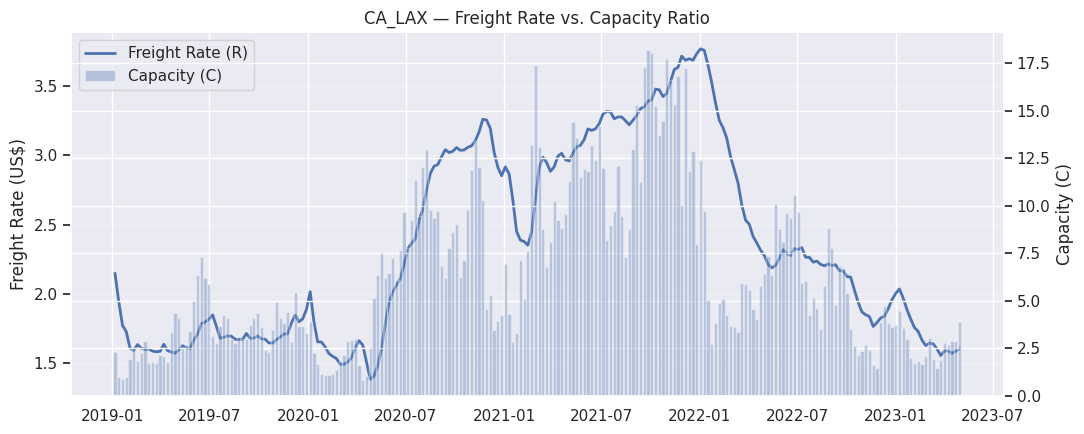

In [39]:
df_chart = df_filtered[df_filtered['id'] == 'CA_LAX']
df_chart

# --- pick the ID and filter (your sample shows 'CA_LAX')
kma_id = "CA_LAX"
df_chart = (
    df_filtered.loc[df_filtered['id'] == kma_id, ['week', 'R', 'C']]
      .dropna(subset=['week'])
      .sort_values('week')
      .copy()
)

# create the plot
fig, ax1 = plt.subplots(figsize=(11, 4.5))

# left y-axis: R as line
ax1.plot(df_chart['week'], df_chart['R'], label='Freight Rate (R)', linewidth=2, zorder=3)
ax1.set_ylabel('Freight Rate (US$)')
ax1.grid(True, axis='y', alpha=0.3)

# right y-axis: E as bars
ax2 = ax1.twinx()
# width given in days when x is datetime; 6 keeps bars nearly a week wide
ax2.bar(df_chart['week'], df_chart['C'], width=6, alpha=0.35, label='Capacity (C)', zorder=1)
ax2.set_ylabel('Capacity (C)')

# x-axis formatting
# ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# one legend combining both axes
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

ax1.set_title(f"{kma_id} — Freight Rate vs. Capacity Ratio")
fig.tight_layout()
plt.show()


### Smothing Features and Capacity Ratio

In [40]:
df_filtered = df_filtered.sort_values(['id', 't']).reset_index(drop=True)

# --- Helper: LOWESS per group, returns a Series aligned to original index
def lowess_per_group(g:pd.DataFrame, ycol: str, xcol: str = 't', frac: float = 0.15):
    x = g[xcol].to_numpy()
    y = g[ycol].to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    out = pd.Series(np.nan, index=g.index)
    if mask.sum() >= 3:  # need a few points for smoothing
        sm = lowess(y[mask], x[mask], frac=frac, return_sorted=False)
        out.loc[g.index[mask]] = sm
    return out

# --- LOWESS smoothing of L and E by id
df_filtered['L_smooth'] = df_filtered.groupby('id', group_keys=False).apply(lambda g: lowess_per_group(g, 'L'))
df_filtered['E_smooth'] = df_filtered.groupby('id', group_keys=False).apply(lambda g: lowess_per_group(g, 'E'))

# --- Replace L and E with ceil(smoothed) where available
df_filtered.loc[df_filtered['L_smooth'].notna(), 'L'] = np.ceil(df_filtered.loc[df_filtered['L_smooth'].notna(), 'L_smooth'])
df_filtered.loc[df_filtered['E_smooth'].notna(), 'E'] = np.ceil(df_filtered.loc[df_filtered['E_smooth'].notna(), 'E_smooth'])

# Clean temp columns if you don't need them
df_filtered = df_filtered.drop(columns=['L_smooth', 'E_smooth'])

# --- C = L/E -> Replace CAPACITY Indicator
df_filtered['C'] = df_filtered['L'] / df_filtered['E']

# Comute logs, set to NaN if original value is <= 0
for col_src, col_out in [('R', 'r'), ('C', 'c'), ('F', 'f')]:
    valid = df_filtered[col_src] > 0
    df_filtered[col_out] = np.where(valid, np.log(df_filtered[col_src]), np.nan)

df_filtered

/tmp/ipykernel_30786/2141676381.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered['L_smooth'] = df_filtered.groupby('id', group_keys=False).apply(lambda g: lowess_per_group(g, 'L'))
/tmp/ipykernel_30786/2141676381.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered['E_smooth'] = df_filtered.groupby('id', group_keys=False).apply(lambda g: lowess_per_group(g, 'E'))


,id,week,lane,R,F,E,L,month,year,t,C,r,c,f
0,CA_LAX,2019-01-06,92,2.147733,0.308179,475566.0,484920.0,1,2019,1,1.019669,0.764413,0.019478,-1.177073
1,CA_LAX,2019-01-13,101,1.944323,0.298158,468111.0,524666.0,1,2019,2,1.120815,0.664914,0.114056,-1.210132
2,CA_LAX,2019-01-20,109,1.772123,0.300776,460754.0,564755.0,1,2019,3,1.225719,0.572179,0.203528,-1.201390
3,CA_LAX,2019-01-27,109,1.726185,0.298936,453499.0,605233.0,1,2019,4,1.334585,0.545914,0.288620,-1.207527
4,CA_LAX,2019-02-03,109,1.606923,0.297776,446340.0,646160.0,2,2019,5,1.447686,0.474321,0.369966,-1.211413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6097,WI_MIL,2023-04-02,116,2.198338,0.519568,403677.0,514651.0,4,2023,222,1.274908,0.787702,0.242874,-0.654758
6098,WI_MIL,2023-04-09,117,2.180318,0.531304,403213.0,470566.0,4,2023,223,1.167041,0.779471,0.154471,-0.632420
6099,WI_MIL,2023-04-16,111,2.137137,0.525436,402725.0,426584.0,4,2023,224,1.059244,0.759467,0.057555,-0.643527
6100,WI_MIL,2023-04-23,115,2.061471,0.525436,402207.0,382717.0,4,2023,225,0.951542,0.723420,-0.049671,-0.643527


### Chart 3 - Histogram of feature distribution

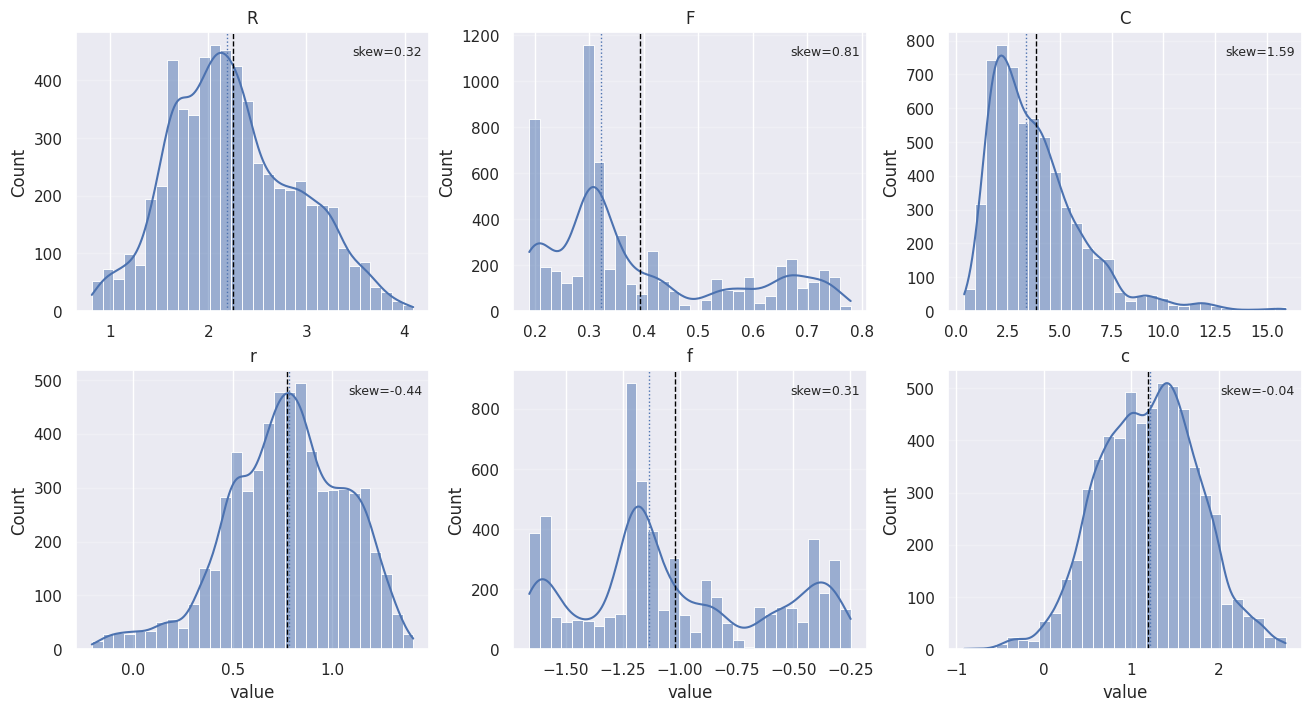

In [41]:
sns.set_theme()

cols_top = ['R', 'F', 'C']
cols_bot = ['r', 'f', 'c']

fig, axes = plt.subplots(2, 3, figsize=(13, 7), constrained_layout=True)

def plot_hist(ax, s, title):
    s = pd.Series(s).dropna()
    sns.histplot(s, bins=30, kde=True, ax=ax)
    # mean/median
    m, md = s.mean(), s.median()
    ax.axvline(m, linestyle='--', linewidth=1, color = 'black')
    ax.axvline(md, linestyle=':',  linewidth=1)
    # annotate skewness
    ax.text(0.98, 0.95, f"skew={skew(s, nan_policy='omit'):.2f}",
            transform=ax.transAxes, ha='right', va='top', fontsize=9)
    ax.set_title(title)
    ax.grid(True, axis='y', alpha=0.25)

# top row: R, F, C
for j, col in enumerate(cols_top):
    plot_hist(axes[0, j], df_filtered[col], col)

# bottom row: r, f, c=
for j, col in enumerate(cols_bot):
    plot_hist(axes[1, j], df_filtered[col], col)

# nicer labels (optional)
for ax in axes[1]:
    ax.set_xlabel("value")
for ax in axes[0]:
    ax.set_xlabel("")

plt.show()


### Chart 4 - Scatter plots - relating features

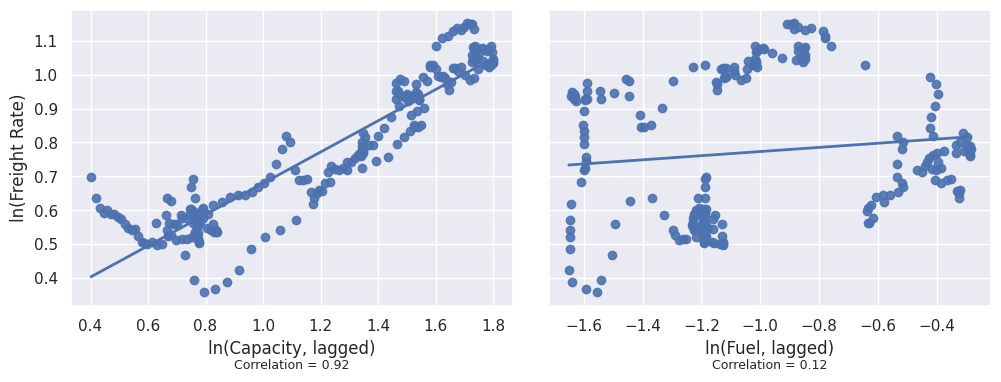

In [42]:
df_filtered = df_filtered.sort_values(['t', 'id']).reset_index(drop=True)

# --- Logs (guard against non-positive values)
for src, dst in [('R','lnR'), ('F','lnF'), ('C','lnC')]:
    valid = df_filtered[src] > 0
    df_filtered[dst] = np.where(valid, np.log(df_filtered[src]), np.nan)

# --- Cross-section means by time t
means_t = (
    df_filtered.groupby('t')[['lnR', 'lnC', 'lnF']]
      .mean()
      .sort_index()
      .rename(columns={'lnR': 'lnR_m', 'lnC': 'lnC_m', 'lnF': 'lnF_m'})
)

# 1-period lag of time-means
means_t['L_lnC_m'] = means_t['lnC_m'].shift(1)
means_t['L_lnF_m'] = means_t['lnF_m'].shift(1)

# Data for each subplot (drop missing)
plot_c = means_t[['lnR_m', 'L_lnC_m']].dropna().rename(columns={'L_lnC_m': 'x'})
plot_f = means_t[['lnR_m', 'L_lnF_m']].dropna().rename(columns={'L_lnF_m': 'x'})

# Plot chart 
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.subplots_adjust(wspace=0.08, bottom=0.12) 

# panel data
pairs = [
    (plot_c, "ln(Capacity, lagged)", axes[0]),
    (plot_f, "ln(Fuel, lagged)",    axes[1]),
]

for data, xlabel, ax in pairs:
    sns.regplot(data=data, x='x', y='lnR_m', ci=None,
                scatter_kws={'s': 36, 'alpha': 0.9},
                line_kws={'linewidth': 2}, ax=ax)
    ax.set_xlabel(xlabel)

    # Pearson correlation (dropna already done in plot_* frames)
    r, p = pearsonr(data['x'], data['lnR_m'])

    # put text BELOW the x-axis; (-0.18) is below the axis in Axes coords
    ax.text(0.5, -0.18, f"Correlation = {r:.2f}",
            transform=ax.transAxes, ha='center', va='top', fontsize=9)

# labels / cosmetics
axes[0].set_ylabel("ln(Freight Rate)")
axes[1].set_ylabel("")
# for ax in axes:
#     ax.set_box_aspect(None) 
    # ax.set_box_aspect(1)

# tighten spacing & margins (no tight_layout())
fig.subplots_adjust(left=0.07, right=0.99, top=0.96, bottom=0.22, wspace=0.08)

plt.show()


## System GMN Estimation
### Intuition
* Estimate two equations (endogenous variables) and then build a system from them.

* With two endogenous variables $y_{it} = \begin{bmatrix} r_{it} \\ c_{it} \end{bmatrix}$ and lag order 2:


$$
\begin{bmatrix} r_{it} \\ c_{it} \end{bmatrix}
=
A_1 \begin{bmatrix} r_{i,t-1} \\ c_{i,t-1} \end{bmatrix}
+
A_2 \begin{bmatrix} r_{i,t-2} \\ c_{i,t-2} \end{bmatrix}
+
B\,x_{it} + \alpha_i + \tau_t + u_{it}.
$$

- $(A_1, A_2)$ capture **own** and **cross** lag effects (the VAR dynamics).
- $(x_{it})$ are **exogenous** controls (e.g., $(f_t, f_{t-1})$).
- $(\alpha_i)$ are unit fixed effects; $(\tau_t)$ are time dummies.
- In a **panel** VAR we pool coefficients across \(i\) and typically use panel GMM to handle endogeneity of lagged \(y\).

Written as two separate equations (the rows of the system):

$$
\begin{aligned}
r_{it} &= a_{11}^{(1)} r_{i,t-1} + a_{12}^{(1)} c_{i,t-1}
        + a_{11}^{(2)} r_{i,t-2} + a_{12}^{(2)} c_{i,t-2}
        + \beta_r^\top x_{it} + \alpha_i^{r} + \tau_t^{r} + u_{it}^{r},\\[4pt]
c_{it} &= a_{21}^{(1)} r_{i,t-1} + a_{22}^{(1)} c_{i,t-1}
        + a_{21}^{(2)} r_{i,t-2} + a_{22}^{(2)} c_{i,t-2}
        + \beta_c^\top x_{it} + \alpha_i^{c} + \tau_t^{c} + u_{it}^{c}.
\end{aligned}
$$


That’s why a PVAR with $[r,c]$ has **two equations**: one with $r_{it}$ as the dependent variable and one with $(c_{it})$. Each equation provides one **row** of $(A_1)$ and $(A_2)$.


#### Post-estimation tests: What to monitor after each run:

* **instruments (aim ≤ # groups; your table shows 30 groups KMAs).**

* Hansen p-value ⇒ should be finite and not extreme (avoid ~1.00 or ~0.00).

* Arellano–Bond ⇒ AR(1) p < 0.05 (expected), AR(2) p > 0.10.


## Baseline Model - Full Model

In [46]:
import numpy as np
np.NaN = np.nan 
from pydynpd import regression

df_filtered = df_filtered.sort_values(['id','t']).copy()

# pydynpd expects concrete ids and an integer-ish time index
df_filtered['t'] = df_filtered['t'].astype(int)

# Compute Equations
# Equation for r_t  (lags of r and c, exog f and L1.f)
cmd_r = 'r L(1:2).r L(1:2).c f L1.f | gmm(r, 2:5) gmm(c, 2:5) iv(f L1.f) | timedumm nolevel'
res_r = regression.abond(cmd_r, df_filtered, ['id','t'])

# Equation for c_t  (symmetric)
cmd_c = 'c L(1:2).r L(1:2).c f L1.f | gmm(r, 2:5) gmm(c, 2:5) iv(f L1.f) | timedumm nolevel'
res_c = regression.abond(cmd_c, df_filtered, ['id','t'])

# Look at results (tables include Hansen J and AB AR(1)/AR(2) tests)
print(res_r)   # r-equation summary
print(res_c)   # c-equation summary

# Get VAR (2) coefficient matrices A1, A2 from the two regressions
def coef(model, name, default=0.0):
    tbl = model.models[0].regression_table.set_index('variable')
    return float(tbl.loc[name, 'coefficient']) if name in tbl.index else default

A1 = np.array([[coef(res_r, 'L1.r'), coef(res_r, 'L1.c')],
               [coef(res_c, 'L1.r'), coef(res_c, 'L1.c')]])
A2 = np.array([[coef(res_r, 'L2.r'), coef(res_r, 'L2.c')],
               [coef(res_c, 'L2.r'), coef(res_c, 'L2.c')]])
print(A1)

# companion matrix & stability (like pvarstable)
k = 2
companion = np.block([[A1, A2],
                      [np.eye(k), np.zeros((k, k))]])
eigvals = np.linalg.eigvals(companion)
print("Eigenvalues:", eigvals)
print("Stable (all |λ|<1)?", np.all(np.abs(eigvals) < 1))


 Dynamic panel-data estimation, two-step difference GMM
 Group variable: id                                 Number of obs = 6021      
 Time variable: t                                   Min obs per group: 223    
 Number of instruments = 2003                       Max obs per group: 223    
 Number of groups = 27                              Avg obs per group: 223.00 
+-------+------------+---------------------+------------+-----------+-----+
|   r   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+-------+------------+---------------------+------------+-----------+-----+
|  L1.r | -0.0002278 |      0.0008989      | -0.2534425 | 0.7999263 |     |
|  L2.r | -0.0030530 |      0.0005492      | -5.5589666 | 0.0000000 | *** |
|  L1.c | 0.0002596  |      0.0000495      | 5.2470190  | 0.0000002 | *** |
|  L2.c | 0.0002876  |      0.0000498      | 5.7722661  | 0.0000000 | *** |
|   f   | 0.0001615  |      0.0002902      | 0.5567395  | 0.5777054 |     |
|  L1.f | -0.0014725

## Model 2 - Drop instruments - Hansem test is bad / Nickel Bias

### Collapse Instruments (Roodman, 2009)
### Model 2.1 -  Keep weekly time dummies, but collapse and shorten the window

In [47]:
# diff-GMM (no level eq.), collapsed instruments, shorter windows (2:3)
cmd_r = 'r L(1:2).r L(1:2).c f L1.f | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f) | timedumm nolevel collapse'
res_r = regression.abond(cmd_r, df_filtered, ['id','t'])

cmd_c = 'c L(1:2).r L(1:2).c f L1.f | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f) | timedumm nolevel collapse'
res_c = regression.abond(cmd_c, df_filtered, ['id','t'])

print(res_r)   # r-equation summary
print(res_c)   # c-equation summary


 Dynamic panel-data estimation, two-step difference GMM
 Group variable: id                                Number of obs = 6021      
 Time variable: t                                  Min obs per group: 223    
 Number of instruments = 229                       Max obs per group: 223    
 Number of groups = 27                             Avg obs per group: 223.00 
+-------+------------+---------------------+------------+-----------+-----+
|   r   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+-------+------------+---------------------+------------+-----------+-----+
|  L1.r | -0.0017938 |      0.0005629      | -3.1867876 | 0.0014386 |  ** |
|  L2.r | -0.0007334 |      0.0002688      | -2.7289236 | 0.0063541 |  ** |
|  L1.c | 0.0002622  |      0.0001713      | 1.5301681  | 0.1259751 |     |
|  L2.c | 0.0004774  |      0.0001252      | 3.8125506  | 0.0001375 | *** |
|   f   | 0.0015328  |      0.0013191      | 1.1620127  | 0.2452303 |     |
|  L1.f | 0.0007006  |  

### Model 2.2 - — Drop weekly timedum dummies

In [49]:
cmd_r = 'r L(1:2).r L(1:2).c f L1.f | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f) |  collapse'
res_r = regression.abond(cmd_r, df_filtered, ['id','t'])

cmd_c = 'c L(1:2).r L(1:2).c f L1.f | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f) |  collapse'
res_c = regression.abond(cmd_c, df_filtered, ['id','t'])

# Look at results (tables include Hansen J and AB AR(1)/AR(2) tests)
print(res_r)   # r-equation summary
print(res_c)   # c-equation summary

 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                              Number of obs = 6021      
 Time variable: t                                Min obs per group: 223    
 Number of instruments = 9                       Max obs per group: 223    
 Number of groups = 27                           Avg obs per group: 223.00 
+------+------------+---------------------+-------------+-----------+-----+
|  r   |   coef.    | Corrected Std. Err. |      z      |   P>|z|   |     |
+------+------------+---------------------+-------------+-----------+-----+
| L1.r | 1.3604555  |      0.0280195      |  48.5539342 | 0.0000000 | *** |
| L2.r | -0.5699366 |      0.0282955      | -20.1423180 | 0.0000000 | *** |
| L1.c | -0.3107057 |      0.0556544      |  -5.5827723 | 0.0000000 | *** |
| L2.c | 0.3678467  |      0.0567048      |  6.4870509  | 0.0000000 | *** |
|  f   | 0.0453894  |      0.0149751      |  3.0309901  | 0.0024375 |  ** |
| L1.f | -0.0532354 |      0.0134991

### Model 2.3 - Monthly instruments

In [50]:
# build coarse time FE
dummies = pd.get_dummies(df_filtered[['month']].astype('category'),
                         drop_first=True, prefix=['m'])
df_fe = pd.concat([df_filtered, dummies], axis=1)
iv_fe = ' '.join(dummies.columns)  # space-separated list

cmd_r = f'r L(1:2).r L(1:2).c f  {iv_fe} | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f {iv_fe}) |  collapse'
res_r = regression.abond(cmd_r, df_fe, ['id','t'])

cmd_c = f'c L(1:2).r L(1:2).c f  {iv_fe} | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f {iv_fe}) |  collapse'
res_c = regression.abond(cmd_c, df_fe, ['id','t'])

print(res_r)   # r-equation summary
print(res_c)   # c-equation summary


 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                               Number of obs = 6021      
 Time variable: t                                 Min obs per group: 223    
 Number of instruments = 20                       Max obs per group: 223    
 Number of groups = 27                            Avg obs per group: 223.00 
+------+------------+---------------------+-------------+-----------+-----+
|  r   |   coef.    | Corrected Std. Err. |      z      |   P>|z|   |     |
+------+------------+---------------------+-------------+-----------+-----+
| L1.r | 1.3419750  |      0.0299069      |  44.8718103 | 0.0000000 | *** |
| L2.r | -0.5422817 |      0.0261281      | -20.7547466 | 0.0000000 | *** |
| L1.c | -0.3584845 |      0.0694378      |  -5.1626700 | 0.0000002 | *** |
| L2.c | 0.4099280  |      0.0719978      |  5.6936209  | 0.0000000 | *** |
|  f   | -0.0096852 |      0.0036922      |  -2.6231513 | 0.0087121 |  ** |
| m_2  | 0.0018590  |      0.002

### Model 2.4 - Quartely instruments

In [52]:
df_filtered['quarter'] = ((df_filtered['month']-1)//3 + 1).astype('int')
dummies = pd.get_dummies(df_filtered[['quarter']].astype('category'),
                         drop_first=True, prefix=['q'])
df_fe = pd.concat([df_filtered, dummies], axis=1)
iv_fe = ' '.join(dummies.columns)

cmd_r = f'r L(1:2).r L(1:2).c f  {iv_fe} | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f {iv_fe}) |  collapse'
res_r = regression.abond(cmd_r, df_fe, ['id','t'])

cmd_c = f'c L(1:2).r L(1:2).c f {iv_fe} | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f {iv_fe}) | collapse'
res_c = regression.abond(cmd_c, df_fe, ['id','t'])

print(res_r) 
print(res_c) 

 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                               Number of obs = 6021      
 Time variable: t                                 Min obs per group: 223    
 Number of instruments = 12                       Max obs per group: 223    
 Number of groups = 27                            Avg obs per group: 223.00 
+------+------------+---------------------+-------------+-----------+-----+
|  r   |   coef.    | Corrected Std. Err. |      z      |   P>|z|   |     |
+------+------------+---------------------+-------------+-----------+-----+
| L1.r | 1.3471605  |      0.0288901      |  46.6304799 | 0.0000000 | *** |
| L2.r | -0.5513735 |      0.0269282      | -20.4756822 | 0.0000000 | *** |
| L1.c | -0.3134394 |      0.0568075      |  -5.5175744 | 0.0000000 | *** |
| L2.c | 0.3659509  |      0.0581883      |  6.2890772  | 0.0000000 | *** |
|  f   | -0.0083810 |      0.0035580      |  -2.3555598 | 0.0184948 |  *  |
| q_2  | -0.0115780 |      0.001

### Model 2.5 - H2 Monthly instruments

In [53]:
# Make a Jul–Dec indicator
df_fe = df_filtered.copy()
df_fe['H2'] = (df_fe['month'] >= 7).astype('int8')   # 1 if month ∈ {7,…,12}

# 2) use it as an exogenous regressor and instrument
cmd_r = 'r L(1:2).r L(1:2).c f H2 | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f H2) | collapse'
res_r = regression.abond(cmd_r, df_fe, ['id','t'])

cmd_c = 'c L(1:2).r L(1:2).c f H2 | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f H2) | collapse'
res_c = regression.abond(cmd_c, df_fe, ['id','t'])

print(res_r)
print(res_c)


 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                               Number of obs = 6021      
 Time variable: t                                 Min obs per group: 223    
 Number of instruments = 10                       Max obs per group: 223    
 Number of groups = 27                            Avg obs per group: 223.00 
+------+------------+---------------------+-------------+-----------+-----+
|  r   |   coef.    | Corrected Std. Err. |      z      |   P>|z|   |     |
+------+------------+---------------------+-------------+-----------+-----+
| L1.r | 1.3565982  |      0.0309372      |  43.8500061 | 0.0000000 | *** |
| L2.r | -0.5506224 |      0.0289180      | -19.0407916 | 0.0000000 | *** |
| L1.c | -0.3083013 |      0.0567853      |  -5.4292445 | 0.0000001 | *** |
| L2.c | 0.3614844  |      0.0590595      |  6.1206858  | 0.0000000 | *** |
|  f   | -0.0087262 |      0.0034156      |  -2.5547822 | 0.0106254 |  *  |
|  H2  | 0.0026072  |      0.001

## VAR Stability Test

In [ ]:
def plot_unit_circle(eigvals, title="VAR stability (unit circle)", tol=1e-10):
    eigvals = np.asarray(eigvals)
    mods = np.abs(eigvals)
    stable_mask = mods < (1 - tol)

    fig, ax = plt.subplots(figsize=(5,5))

    # unit circle
    t = np.linspace(0, 2*np.pi, 400)
    ax.plot(np.cos(t), np.sin(t), linestyle='--', linewidth=1)

    # axes
    ax.axhline(0, lw=0.5)
    ax.axvline(0, lw=0.5)

    # eigenvalues
    ax.scatter(eigvals.real[stable_mask], eigvals.imag[stable_mask], s=40, label='|λ| < 1')
    ax.scatter(eigvals.real[~stable_mask], eigvals.imag[~stable_mask], s=60, marker='x', label='|λ| ≥ 1')

    # limits & labels
    lim = 1.1 * max(1.0, mods.max())
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Real(λ)')
    ax.set_ylabel('Imaginary(λ)')
    ax.set_title(f"{title}\nmax |λ| = {mods.max():.3f} → "
                 f"{'STABLE' if stable_mask.all() else 'UNSTABLE'}")
    ax.legend(loc='upper left', frameon=False)
    plt.show()

# Example using your companion matrix:
eigvals = np.linalg.eigvals(companion)
print("Eigenvalues:", eigvals)
plot_unit_circle(eigvals)


* All the eigenvalues lie inside the unit circle.
* VAR satisfies stability condition.


## Compute IRF Functions

In [ ]:

# ---- Build MA(∞) coefficients Ψ_h from VAR(p) ----
def ma_coefs(A_list, H):
    """A_list = [A1, A2, ..., Ap], each k×k. Returns Ψ[0..H], each k×k."""
    k = A_list[0].shape[0]
    p = len(A_list)
    Psi = [np.eye(k)]
    for h in range(1, H+1):
        S = np.zeros((k, k))
        for ell in range(1, min(p, h) + 1):
            S += Psi[h-ell] @ A_list[ell-1]
        Psi.append(S)
    return Psi  # length H+1

# ---- IRF calculator ----
def compute_irf(A_list, H=12, Sigma=None, method="chol"):
    """
    method: 'chol' (orthogonalized) or 'generalized' (Pesaran–Shin).
    Returns array IRF[h, i, j] = response of variable i to shock in j at horizon h.
    """
    k = A_list[0].shape[0]
    Psi = ma_coefs(A_list, H)
    if Sigma is None:
        Sigma = np.eye(k)

    if method == "chol":
        # orthogonalized 1-s.d. shocks: P @ P' = Sigma
        # If Sigma not PD, small ridge helps
        try:
            P = np.linalg.cholesky(Sigma)
        except np.linalg.LinAlgError:
            P = np.linalg.cholesky(Sigma + 1e-10 * np.eye(k))
        IRF = np.stack([Psi[h] @ P for h in range(H+1)], axis=0)

    elif method == "generalized":
        # GIRF: IRF_h(i,j) = e_i' Ψ_h Σ e_j / sqrt(e_j' Σ e_j)
        denom = np.sqrt(np.diag(Sigma))  # std of reduced-form shocks
        IRF = np.zeros((H+1, k, k))
        for h in range(H+1):
            A = Psi[h] @ Sigma
            for j in range(k):
                IRF[h, :, j] = A[:, j] / (denom[j] if denom[j] > 0 else 1.0)
    else:
        raise ValueError("method must be 'chol' or 'generalized'")
    return IRF  # shape (H+1, k, k)

# ---- Try to estimate Σu from your AB results (fallback: identity) ----
def residual_covariance_or_I(res_r, res_c):
    try:
        e_r = np.asarray(res_r.models[0].residuals).ravel()
        e_c = np.asarray(res_c.models[0].residuals).ravel()
        n = min(len(e_r), len(e_c))
        return np.cov(np.vstack([e_r[:n], e_c[:n]]))
    except Exception:
        return np.eye(2)


# horizon
H = 8

# residual covariance (fallback to I if unavailable)
Sigma = residual_covariance_or_I(res_r, res_c)

# choose 'chol' (order matters: variables are [r, c]) or 'generalized'
IRF = compute_irf([A1, A2], H=H, Sigma=Sigma, method="chol")

t = np.arange(H + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# r response to c shock
axes[0].plot(t, IRF[:, 0, 1], lw=2)
axes[0].axhline(0, lw=0.8)
axes[0].set_title("Response of r to shock in c")
axes[0].set_xlabel("Horizon")
axes[0].set_ylabel("IRF")
axes[0].grid(alpha=0.25)

# c response to r shock
axes[1].plot(t, IRF[:, 1, 0], lw=2)
axes[1].axhline(0, lw=0.8)
axes[1].set_title("Response of c to shock in r")
axes[1].set_xlabel("Horizon")
axes[1].set_ylabel("IRF")
axes[1].grid(alpha=0.25)

fig.subplots_adjust(wspace=0.15, bottom=0.12)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS

# --- prep
df = df.sort_values(['id','t']).copy()
# create lags by id
for col, Ls in [('r',[1,2]), ('c',[1,2]), ('f',[1])]:
    for L in Ls:
        df[f'L{L}_{col}'] = df.groupby('id')[col].shift(L)

# keep rows with full set of regressors
need = ['r','c','f','L1_r','L2_r','L1_c','L2_c','L1_f']
df2 = df.dropna(subset=need).copy()

# panel index
panel = df2.set_index(['id','t'])

# --- VARX(2) via FE-OLS (entity + time effects), clustered SEs
X_r = panel[['L1_r','L2_r','L1_c','L2_c','f','L1_f']]
y_r = panel['r']
res_r = PanelOLS(y_r, X_r, entity_effects=True, time_effects=True)\
          .fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

X_c = panel[['L1_r','L2_r','L1_c','L2_c','f','L1_f']]
y_c = panel['c']
res_c = PanelOLS(y_c, X_c, entity_effects=True, time_effects=True)\
          .fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

print(res_r.summary)
print(res_c.summary)

# --- Build VAR(2) coefficient matrices A1, A2 (VARX ignores exogenous for A's)
def b(res, name): return float(res.params.get(name, 0.0))

A1 = np.array([[b(res_r,'L1_r'), b(res_r,'L1_c')],
               [b(res_c,'L1_r'), b(res_c,'L1_c')]])

A2 = np.array([[b(res_r,'L2_r'), b(res_r,'L2_c')],
               [b(res_c,'L2_r'), b(res_c,'L2_c')]])

print("A1:\n", A1)
print("A2:\n", A2)

# --- Stability (unit-circle / companion)
k = 2
companion = np.block([[A1, A2],
                      [np.eye(k), np.zeros((k,k))]])
eigvals = np.linalg.eigvals(companion)
print("Eigenvalues:", eigvals)
print("Stable (all |λ|<1)?", np.all(np.abs(eigvals) < 1))
print("Companion matrix:\n", companion)


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [ ]:
# ---------- 1) Build a single multivariate time series ----------
# r = ln(R), c = ln(C), f = ln(F) should already exist
ts = (
    df.sort_values('t')
      .groupby('t')[['r', 'c', 'f']]
      .mean()
      .dropna()
      .copy()
)

# include a lag of f as exogenous too
ts['L1_f'] = ts['f'].shift(1)
ts = ts.dropna()

endog = ts[['r','c']]
# exog =  ts[['f']] 
exog  = ts[['f','L1_f']]  

# ---------- 2) Fit VARMAX(p, q) with exogenous (use q=0, pure VARX) ----------
best = None
for p in (1,2,3,4):              # small search over AR order
    try:
        mod = sm.tsa.VARMAX(endog, order=(p, 0), exog=exog,
                            trend='c', enforce_stationarity=True, enforce_invertibility=True)
        res = mod.fit(disp=False, maxiter=1000)
        if (best is None) or (res.aic < best[0]):
            best = (res.aic, p, res)
    except Exception as e:
        pass

aic, p, res = best
print(f"Selected VARMAX({p},0) by AIC={aic:.2f}")
print(res.summary())
